<a href="https://colab.research.google.com/github/it22258380/DL-Assignment/blob/feature%2FAkash/TCN_Akash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import folium
from sklearn.linear_model import LinearRegression

# Setup plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [4]:
#Extracting the SriLanka Weather data set
weather = pd.read_csv('/content/drive/My Drive/Deep learning assigment/SriLanka_Weather_Dataset.csv')
weather.head(5)
cities = pd.DataFrame({'Cities' : weather.city.unique()})
latitudes = []
longitudes = []
# cities.head()
for i in range(cities['Cities'].size):
    lat = weather.loc[weather['city'] == cities['Cities'].iloc[i]]['latitude'].iloc[0]
    long = weather.loc[weather['city'] == cities['Cities'].iloc[i]]['longitude'].iloc[0]
    latitudes.append(lat)
    longitudes.append(long)
cities['latitude'] = latitudes; cities['longitude'] = longitudes

# Weather Data Collected Cities

In [ ]:
# Create a map
m_1 = folium.Map(width = 600, height = 400, location=[7.877083,80.697917], tiles='cartodbpositronnolabels', zoom_start=7, zoom_control=False,
               scrollWheelZoom=False,
               dragging=False)


for idx, row in cities.iterrows():
    folium.Circle(location = [row['latitude'], row['longitude']],
                  radius = 2000,
                 ).add_child(folium.Popup(row['Cities'])).add_to(m_1)
# Display the map
m_1

# Visualizing Data for Kandy

In [ ]:
cities = weather.city.unique()
#collecting data for kandy
weather_sl_kandy = weather[weather['city'] == 'Kandy']
#changing date format
def dateTime(row):
    new_time = pd.to_datetime(row.time)
    row['time'] = new_time
    return row

weatherDate = weather_sl_kandy.apply(dateTime, axis='columns')
#dropping unwanted, redundant columns
weather_kandy = weatherDate.drop(columns = ['country', 'temperature_2m_max', 'temperature_2m_min', 'sunrise', 'sunset','apparent_temperature_max','apparent_temperature_min','snowfall_sum', 'longitude', 'latitude', 'elevation'])
weather_kandy.set_index('time', drop = True, inplace = True)
weather_kandy.head()

,weathercode,temperature_2m_mean,apparent_temperature_mean,shortwave_radiation_sum,precipitation_sum,rain_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,city
time,,,,,,,,,,,,
2010-01-01,2,22.0,23.8,18.09,0.0,0.0,0.0,15.3,38.9,57,3.43,Kandy
2010-01-02,2,22.2,24.8,15.47,0.0,0.0,0.0,13.3,33.1,46,2.95,Kandy
2010-01-03,51,22.1,25.0,14.99,0.1,0.1,1.0,10.7,28.1,40,2.84,Kandy
2010-01-04,51,21.9,24.3,16.55,0.6,0.6,2.0,10.4,29.2,23,3.16,Kandy
2010-01-05,1,20.8,22.6,22.68,0.0,0.0,0.0,9.7,27.0,28,4.18,Kandy


Text(0.5, 1.0, 'Monthly Rainfall from 2010 - 2020 in Sri Lanka')

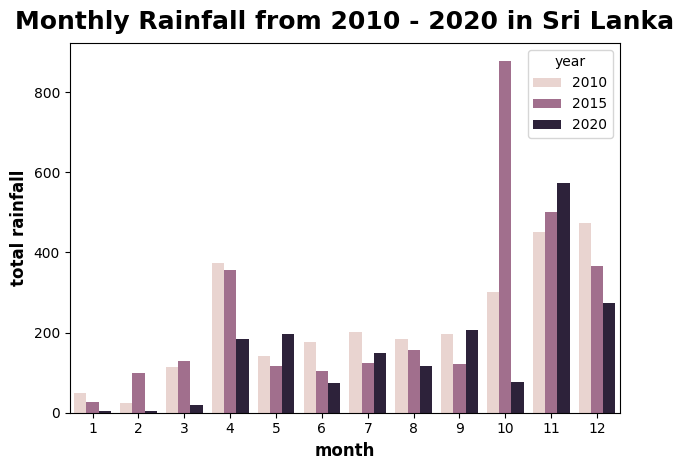

In [ ]:
# months = weather_kandy.month.unique()
annual_rainfall = weather_kandy.groupby([weather_kandy.index.year, weather_kandy.index.month]).rain_sum.sum()
annual_rainfall.index.names = ['year', 'month']

rainfall_series = annual_rainfall.loc[[2010, 2015, 2020]]
monthly_rainfall_by_year = pd.DataFrame({'total rainfall' : rainfall_series}).reset_index()

sns.barplot( x= 'month' , y = 'total rainfall', hue = 'year', data = monthly_rainfall_by_year)
plt.title('Monthly Rainfall from 2010 - 2020 in Sri Lanka')

**2015 flooding and extreme weather conditions due to higher than usual rainfall during October

<Axes: xlabel='month', ylabel='year'>

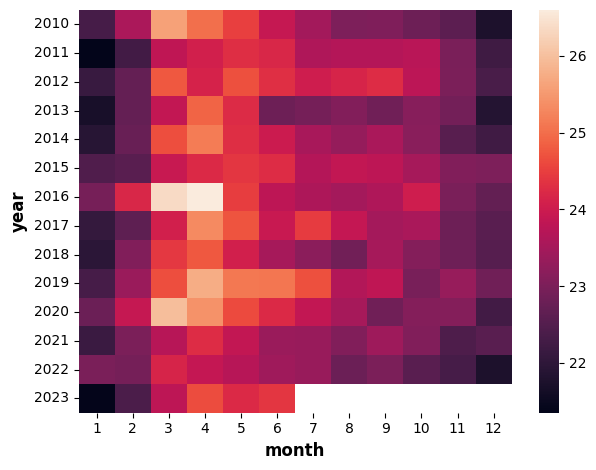

In [ ]:
avg_temp = weather_kandy.groupby([weather_kandy.index.year, weather_kandy.index.month]).aggregate(
{'apparent_temperature_mean' : 'mean', 'temperature_2m_mean' : 'mean'})
avg_temp.index.names = ['year', 'month']

avg_temp = avg_temp.reset_index()

glue = avg_temp.pivot_table(index="year", columns="month", values="temperature_2m_mean")
sns.heatmap(glue)

**El Nino and La Nina 2015-2016, caused significant rise in average temperature in 2016.

**Understanding Weathercodes**

Text(0, 0.5, 'Average Temperature')

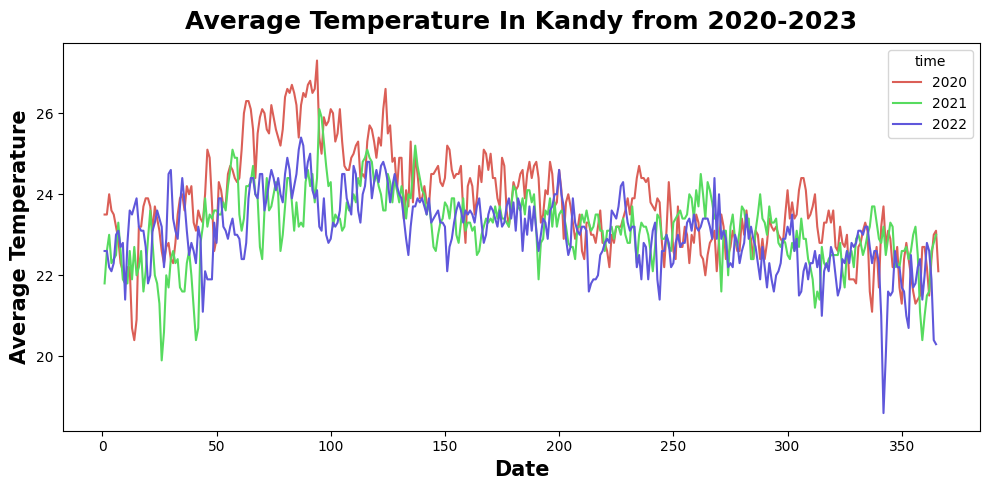

In [ ]:
T = weather_kandy.loc['2020-01-01':'2022-12-31']['temperature_2m_mean']
fig = plt.subplots(figsize=(10, 5))
palette = sns.color_palette("hls", 3)
sns.lineplot(x=T.index.dayofyear,
             y=T,
             hue=T.index.year,
            palette=palette,);
plt.title('Average Temperature In Kandy from 2020-2023')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Average Temperature', fontsize=15)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


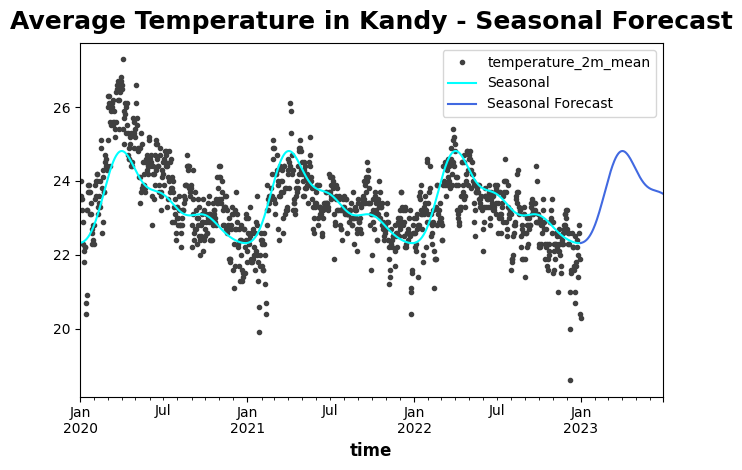

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier
# seasonal forecasting using fourier features
fourier = CalendarFourier(freq="A", order=4)
X = fourier.in_sample(T.index)
y = T
model = LinearRegression()
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = fourier.out_of_sample(steps = 180, index = pd.date_range("2020-01-01", "2022-12-31", freq="D"))
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Average Temperature in Kandy - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal", color = 'cyan')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='royalblue')
_ = ax.legend()

In [ ]:
codes_list = weather.weathercode.unique()
codes_list

array([ 2, 51,  1,  3, 53, 61, 63,  0, 65, 55])

| Weather Code      | Description |
| ----------- | ---------- |
| 0   | Cloud development not observed or observable|
| 1   | Clouds dissolving or becoming less developed |
| 2   | State of sky on the whole unchanged        |
| 3   | Clouds generally forming or developing      |
| 51  | Drizzle, not freezing, continuous ( slight at time of observation)|
| 53  | Drizzle, not freezing, continuous ( moderate at time of observation) |
| 55  | Drizzle, not freezing, continuous ( heavy (dense) at time of observation)|
| 61  | Rain, not freezing, continuous ( slight at time of observation)|
| 63  | Rain, not freezing, continuous ( moderate at time of observation)|
| 65  | Rain, not freezing, continuous ( heavy at time of observation)|

 **There may be serial dependence, therefore I am going to use lag features for forecasting rain.

Text(0, 0.5, 'Total Rainfall')

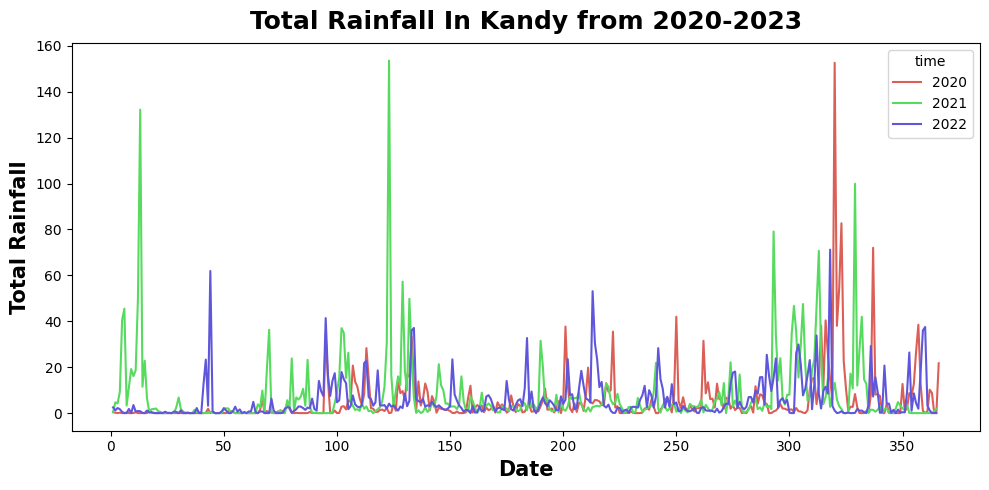

In [ ]:
R = weather_kandy.loc['2020-01-01':'2022-12-31']['rain_sum']
fig = plt.subplots(figsize=(10, 5))
palette = sns.color_palette("hls", 3)
sns.lineplot(x=R.index.dayofyear,
             y=R,
             hue=R.index.year,
            palette=palette,);
plt.title('Total Rainfall In Kandy from 2020-2023')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Total Rainfall', fontsize=15)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


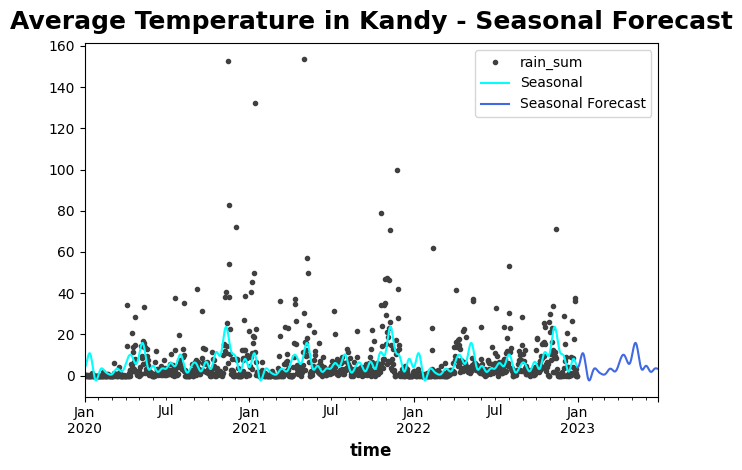

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier
# seasonal forecasting using fourier features
fourier = CalendarFourier(freq="A", order=18)
X = fourier.in_sample(R.index)
y = R
model = LinearRegression()
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = fourier.out_of_sample(steps = 180, index = pd.date_range("2020-01-01", "2022-12-31", freq="D"))
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Average Temperature in Kandy - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal", color = 'cyan')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='royalblue')
_ = ax.legend()

Using lag features to check if there is serial dependence.